In [60]:
from time import time, sleep
from datetime import date

from requests import get
import json

from multiprocessing.pool import ThreadPool as Pool

import haversine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def vehicle_df_creator(vehicles):
    
    vehicles_df = pd.DataFrame(vehicles['list']).drop(['stale', 'serviceDate', 'stopSequence', 'lastUpdateTime', 'status', 'congestionLevel', 'bearing', 'capacity', 'stopDistancePercent', 'wheelchairAccessible', 'style', 'deviated'], 1)
    vehicles_df = pd.concat([vehicles_df, pd.json_normalize(vehicles_df['location'])], 1)

    vehicles_df = vehicles_df.merge(routes, left_on = 'routeId', right_on = 'id', how = 'left')
    vehicles_df = vehicles_df.merge(stops_df[['id', 'name']], left_on = 'stopId', right_on = 'id', how = 'left')

    vehicles_df.drop(['location', 'type', 'routeId', 'stopId', 'id_x', 'id_y'], 1, inplace = True)
    vehicles_df.rename(columns = {'name' : 'Megálló'}, inplace = True)

    return vehicles_df

def plot_MOL_Bubi_dist():
    
    plt.figure()
    sns.displot(data = bikes_data, x = 'bikes', color = '#89bedc', height = 4, aspect = 2, bins = 15)

    plt.title('Elérhető MOL Bubi biciklik')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

def plot_MOL_bubi():
    
    bikes_data['size_for_plot'] = bikes_data['bikes'] + 1

    fig = px.scatter_mapbox(bikes_data, lat = 'lat', lon = 'lon', hover_name = 'name', 
                            #center = {"lat": 45.444617, "lon": 12.321308}, 
                            hover_data = ['name', 'bikes'],
                            title = 'MOL Bubi bicikli-állomások és szabad biciklik száma',
                            zoom = 10.9, size_max = 12, size = 'size_for_plot', 
                            mapbox_style = 'carto-positron', width = 750)
    fig.show()

    bikes_data.drop('size_for_plot', 1, inplace = True)
    
    
def plot_STOP_TYPES():
    
    order = megallok.groupby(['type'])['id'].count().sort_values(ascending  = False)
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'type', data = megallok, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Megálló típusok száma')
    plt.xlabel(None)
    plt.xlim(0, 4900)
    plt.ylabel(None)
    plt.show()
    
def plot_gyujtok_map():

    fig = px.scatter_mapbox(gyujto_stop_count, lat = 'lat', lon = 'lon', hover_name = 'name', 
                            #center = {"lat": 45.444617, "lon": 12.321308}, 
                            hover_data = ['name', 'stop_count'],
                            title = 'BKK gyűjtőállomások elhelyezkedése',
                            labels = {'name' : 'Név', 'stop_count' : 'Megállók száma'},
                            zoom = 10, size_max = 15, size = 'stop_count', 
                            mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    
def plot_stops_map():
    
    megallok['size'] = 1

    fig = px.scatter_mapbox(megallok, lat = 'lat', lon = 'lon', hover_name = 'name',
                            hover_data = ['name', 'routeIds', 'direction'],
                            title = 'BKK megállók és állomások elhelyezkedése', size = 'size', size_max = 4,
                            labels = {'name' : 'Név', 'routeIds' : 'Útvonalak', 'direction' : 'Irány'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    megallok.drop('size', 1, inplace = True)
    
    
def plot_ROUTE_TYPES():
    
    order = routes.groupby(['type'])['id'].count().sort_values(ascending  = False)
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'type', data = routes, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Útvonal típusok száma')
    plt.xlabel(None)
    plt.xlim(0, 350)
    plt.ylabel(None)
    plt.show()
    
    
def plot_CELALLOMAS():
    
    plt.figure(figsize = (9, 7))
    ax = sns.barplot(y = 'name', x = 'Útvonal végállomása', data = celallomasok, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Vég- és kiinduló-állomások')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()
    
def plot_vehicles_map():
    
    vehicles_df['size'] = 1

    fig = px.scatter_mapbox(vehicles_df, lat = 'lat', lon = 'lon', hover_name = 'shortName',
                            hover_data = ['shortName', 'licensePlate', 'model', 'vehicleRouteType', 'From', 'To', 'Megálló'],
                            title = 'Aktuális járművek', size = 'size', size_max = 4.5, 
                            labels = {'label' : 'Irány', 'licensePlate' : 'Rendszám', 'shortName' : 'Jármű száma',
                                      'model' : 'Típus', 'vehicleRouteType' : 'Járműtípus'},
                            color = 'vehicleRouteType', 
                            color_discrete_map = {'BUS' : 'blue', 'TRAM' : 'yellow', 'TROLLEYBUS' : 'red', 'SUBURBAN_RAILWAY' : 'green'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 700, width = 1050)
    fig.show()
    
    vehicles_df.drop('size', 1, inplace = True)
    
    
def plot_VEHICLES_TYPES():
    
    order = vehicles_df['vehicleRouteType'].value_counts()
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'vehicleRouteType', data = vehicles_df, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Aktív járművek típusai')
    plt.xlabel(None)
    plt.xlim(0, vehicles_df['vehicleRouteType'].value_counts().max() + 75)
    plt.ylabel(None)
    plt.show()
    
    
def plot_BUS_TYPE(filter_type = 'ikarus'):
    
    vehicles_df_buses = vehicles_df[vehicles_df['vehicleRouteType'] == 'BUS'].copy()
    
    vehicles_df_buses[filter_type] = 0
    vehicles_df_buses.loc[vehicles_df_buses['model'].str.lower().str.contains(filter_type), filter_type] = 1
    vehicles_df_buses[filter_type] = vehicles_df_buses[filter_type].astype(str)
    
    vehicles_df_buses['size'] = 1

    fig = px.scatter_mapbox(vehicles_df_buses, lat = 'lat', lon = 'lon', hover_name = 'shortName',
                            hover_data = ['shortName', 'licensePlate', 'model', 'vehicleRouteType', 'From', 'To', 'Megálló'],
                            title = 'Busztípusok elhelyezkedése - ' + filter_type, size = 'size', size_max = 5, 
                            labels = {'label' : 'Irány', 'licensePlate' : 'Rendszám', 'shortName' : 'Jármű száma',
                                      'model' : 'Típus', 'vehicleRouteType' : 'Járműtípus'},
                            color = filter_type, 
                            color_discrete_map = {'0': 'lightgreen', '1' : 'brown'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    vehicles_df_buses.drop('size', 1, inplace = True)
    
    
def get_trip_details(i):
    
    trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + i + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
    trip_data = get(trip_link, headers = headers).json()
    
    if 'data' in trip_data.keys():
        trip_data = trip_data['data']
        
        trip_id = i
    
        if 'vehicle' in trip_data['entry'].keys():
            route_id = trip_data['entry']['vehicle']['routeId']    
        else:
            route_id = np.nan

        if 'stopSequence' in trip_data['entry']['stopTimes'][-1].keys():
            stops_num = trip_data['entry']['stopTimes'][-1]['stopSequence']
        else:
            stops_num = np.nan

        if 'shapeDistTraveled' in trip_data['entry']['stopTimes'][-1].keys():
            dist = trip_data['entry']['stopTimes'][-1]['shapeDistTraveled']
        else:
            dist = np.nan

        trip_dict = {'id' : route_id, 'tripId' : trip_id, 'num_of_stops' : stops_num, 'total_distance' : dist}

        return trip_dict
    
    else:
        pass 
    
    
BOXPLOT_PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth' : 1},
    'flierprops':{'markerfacecolor':'black', 'markeredgecolor':'darkgray', 'marker' : 'x'},
    'medianprops':{'color':'black', 'linewidth' : 1},
    'whiskerprops':{'color':'black', 'linewidth' : 1},
    'capprops':{'color':'black', 'linewidth' : 1}
}

def boxplot_sns(data, x, y):  
    
    order = data.groupby([x]).median().sort_values(y, ascending = False)

    plt.figure(figsize = (8, 4))
    sns.boxplot(data = data, y = x, x = y, color = 'blue', fliersize = 2, 
                **BOXPLOT_PROPS, order = order.index)
    plt.xlabel(y)
    plt.ylabel(None)
    plt.title('Járműtípusonkénti eloszlások\n')
    plt.show()

In [2]:
%%time

headers = {'User-agent' : 'Mozilla/5.0 (Windows; U; Windows NT 5.1; de; rv:1.9.1.5) Gecko/20091102 Firefox/3.5.5'}

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")
lat = str(47.497913)
lon = str(19.040236)

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stops_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/stops-for-location.json?lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
bikes_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/bicycle-rental.json?key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'

stops = get(stops_link, headers = headers).json()['data']
bikes = get(bikes_link, headers = headers).json()['data']
sleep(1)
vehicles = get(vehicles_link, headers = headers).json()['data']

Wall time: 2.12 s


### Bikes

In [6]:
bikes_data = pd.DataFrame(bikes['list'])
bikes_data.drop(['type', 'spaces'], 1, inplace = True)

<Figure size 432x288 with 0 Axes>

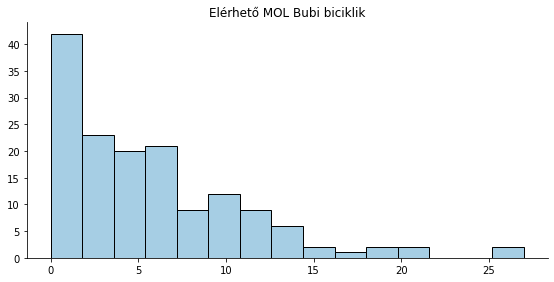

In [7]:
plot_MOL_Bubi_dist()

In [8]:
plot_MOL_bubi()

### Stops

In [9]:
stops_df = pd.DataFrame.from_dict(stops['references']['stops'], orient = 'index').reset_index(drop = True)
stops_df.drop(['description', 'style', 'wheelchairBoarding'], 1, inplace = True)
stops_df.head(3)

id        lat        lon          name      code direction  \
0  BKK_CSF00232  47.513817  19.033945  Margit körút  CSF00232             
1  BKK_CSF00233  47.514609  19.033215  Apostol utca  CSF00233             
2  BKK_CSF01563  47.483975  19.117162   Egészségház  CSF01563             

   locationType locationSubType routeIds stopColorType parentStationId type  
0             1       stop-area       []         OTHER             NaN  NaN  
1             1       stop-area       []         OTHER             NaN  NaN  
2             1       stop-area       []         OTHER             NaN  NaN

In [10]:
gyujtok = stops_df[(stops_df['type'].isnull()) & 
                   (stops_df['stopColorType'] == 'OTHER') & 
                   (stops_df['locationSubType'].isin(['station', 'stop-area']))].copy()

In [11]:
megallok = stops_df[(stops_df['type'].notnull())].copy()
megallok.drop(['locationType', 'locationSubType'], 1, inplace = True)

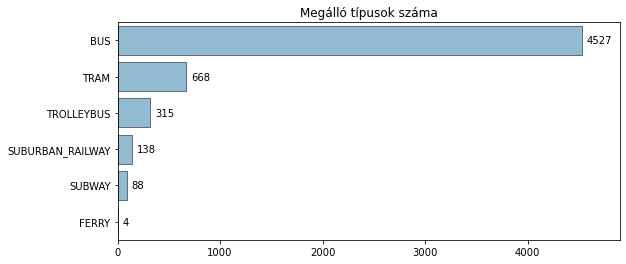

In [12]:
plot_STOP_TYPES()

In [13]:
gyujto_stop_count = megallok.groupby('parentStationId')['id'].count().reset_index().rename(columns = {'id' : 'stop_count'})
gyujto_stop_count = gyujtok[['id', 'lat', 'lon', 'name']].merge(gyujto_stop_count, left_on = 'id', right_on = 'parentStationId').drop('parentStationId', 1)

In [14]:
plot_gyujtok_map()

In [15]:
plot_stops_map()

Calculate distance matrix - find farthest from all stop, closest stops, etc... For this use the 'Gyujok' data, not the actual stops

In [181]:
%%time

distances = []

for i, row_i in gyujtok[gyujtok['id'].str.contains('CS')].iterrows():
    
    _from_id = row_i['id']
    _from_name = row_i['name']
    _from_coord = (row_i['lat'], row_i['lon'])
    
    for j, row_j in gyujtok[gyujtok['id'].str.contains('CS')].iterrows():
        
        _to_id = row_j['id']
        _to_name = row_j['name']
        _to_coord = (row_j['lat'], row_j['lon'])

        _dist = haversine.haversine(_from_coord, _to_coord, unit = haversine.Unit.METERS)

        _dist_dict = {'from_id' : _from_id, 'to_id' : _to_id,
                      'from_name' : _from_name,  'to_name' : _to_name, 'distance' : _dist}
        distances.append(_dist_dict)

Wall time: 12min 58s


In [203]:
%%time

distances_df = pd.DataFrame(distances)
distances_df = distances_df[distances_df['distance'] != 0]
# distances.drop_duplicates('distance', inplace = True)

Wall time: 7.98 s


In [199]:
# distances_df.sort_values('distance', ascending = False)

10 most farthest away from each other stops

In [218]:
farthest = distances_df.groupby('from_id')['distance'].min().sort_values().tail(10)

In [219]:
farthes_df = distances_df[(distances_df['from_id'].isin(farthest.index) )& 
                          (distances_df['distance'].isin(farthest.values))]

farthes_df = farthes_df.drop_duplicates('from_name')
farthes_df = farthes_df.drop_duplicates('distance')
farthes_df.sort_values('distance', ascending = False)

from_id         to_id                        from_name  \
2931251  BKK_CS114912  BKK_CS108475          Monor, autóbusz-állomás   
2496564  BKK_CS008236  BKK_CSF04636                          Ráckeve   
2932677  BKK_CS114914  BKK_CSF04597              Vecsés, Iskola utca   
235225   BKK_CS045883  BKK_CS049185               Fót, Auchan áruház   
3071595  BKK_CSF04634  BKK_CS008231                    Horgásztanyák   
1965195  BKK_CS090783  BKK_CS073308  Pilisvörösvár, MOL-töltőállomás   
240413   BKK_CS008811  BKK_CS009750           Szigetcsép, községháza   

                                      to_name      distance  
2931251           Vecsés, M0 MOL töltőállomás  12976.932108  
2496564                         Angyalisziget   2729.087836  
2932677                         Vecsés-nyugat   2366.753893  
235225                        Szántóföld utca   1928.497773  
3071595  Szigetszentmárton, Dózsa György utca   1495.437963  
1965195                  Solymár vasútállomás   1396.591174  
240413                             Szigetcsép   1238.218908

Farthest away stops:

    - Monor - Vecsés: 13km
    - Ráckeve - Angyalisziget: 2.7km

### Routes

In [16]:
routes = pd.DataFrame.from_dict(stops['references']['routes'], orient = 'index')\
                     .reset_index(drop = True)\
                     .drop(['color', 'textColor', 'agencyId', 'iconDisplayType', 'iconDisplayText', 'style', 'sortOrder', 'bikesAllowed'], 1)

# potlok = routes[routes['id'].str.contains('VP|HP|MP')]
# potlok kiszurese
# routes = routes[~routes['id'].str.contains('VP|HP|MP')]

routes[['From', 'To']] = routes['description'].str.split('|', expand = True)

routes['To'] = routes['To'].str.strip()
routes['From'] = routes['From'].str.strip()

routes.drop(['description'], 1, inplace = True)

routes.head(3)

id shortName type                     From                   To
0  BKK_9960       996  BUS  Cinkotai autóbuszgarázs     Újpest-központ M
1  BKK_9720       972  BUS   Törökbálint, Nyár utca  Móricz Zs. körtér M
2  BKK_9961      996A  BUS  Cinkotai autóbuszgarázs     Újpest-központ M

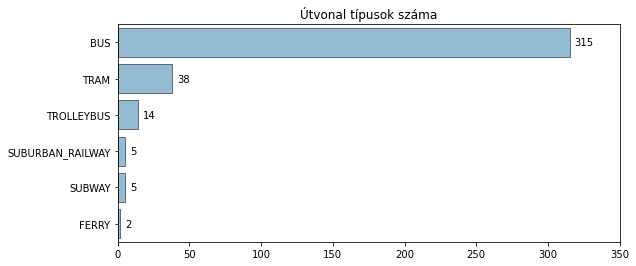

In [17]:
plot_ROUTE_TYPES()

In [18]:
celallomasok = pd.concat([routes['From'], routes['To']]).value_counts().reset_index().rename(columns = {'index' : 'name', 0 : 'Útvonal végállomása'}).head(25)
#celallomasok = stops_df[['name', 'lat', 'lon']].copy().drop_duplicates('name').merge(celallomasok, how = 'right')

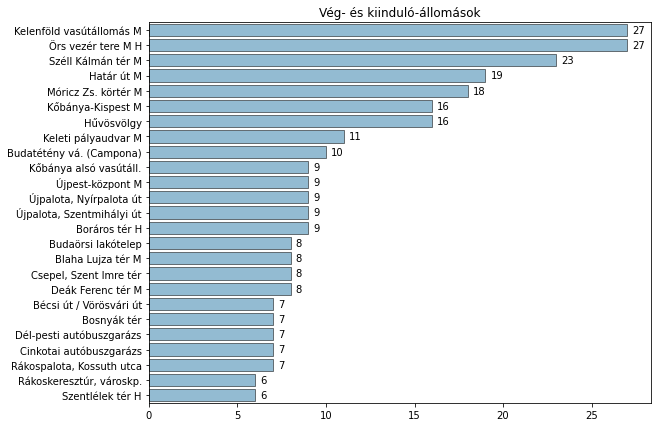

In [19]:
plot_CELALLOMAS()

### Vehicles - currently active on Map

In [20]:
vehicles_df = vehicle_df_creator(vehicles)
vehicles_df.head(3)

vehicleId licensePlate                              model vehicleRouteType  \
0  BKK_6204       NGC155  MERCEDES Citaro O 530 (BKV spec.)              BUS   
1  BKK_4510        V1440                       Ganz csuklós             TRAM   
2  BKK_3663       LOV871     VanHool AG318 csuklós autóbusz              BUS   

                        label         tripId        lat        lon shortName  \
0                         NaN            NaN  47.208290  18.381310       NaN   
1    Kelenföld vasútállomás M  BKK_C36350421  47.471973  19.031809        49   
2  Szentlőrinci úti lakótelep  BKK_C36950481  47.459000  19.119732      123A   

                       From                 To                   Megálló  
0                       NaN                NaN                       NaN  
1  Kelenföld vasútállomás M  Deák Ferenc tér M                Csóka utca  
2     Szentlőrinci úti ltp.         Határ út M  Nagykőrösi út / Határ út

In [21]:
print('Aktív járművek:', vehicles_df.shape[0])

Aktív járművek: 1802


In [22]:
for i in vehicles_df['vehicleRouteType'].unique():
    print(i, '- Modellek\n')
    print(vehicles_df[vehicles_df['vehicleRouteType'] == i]['model'].value_counts())
    print('\n')

BUS - Modellek

MERCEDES Conecto csuklós                    171
MAN Lions City A21 (ArrivaBus)              140
Volvo 7700A típusú csuklós autóbusz         119
MB Citaro C2-S1-G csuklós autóbusz           74
MB Citaro C2-S1 szóló autóbusz               73
MERCEDES Citaro O 530 (BKV spec.)            66
MERCEDES Conecto szóló (BKV)                 66
MAN A21 szóló (Volán, helyi, 3 ajtós)        66
Volvo szóló autóbusz                         50
MERCEDES Conecto 2 szóló autóbusz            49
VanHool A330 CNG típusú szóló autóbusz       39
Ikarus 280-as típusú autóbusz                34
MERCEDES Conecto G 2 csuklós autóbusz        34
VanHool  NewAG300 csuklós autóbusz           28
Modulo M108d szóló autóbusz                  23
MERCEDES Conecto G 3 csuklós busz(Volán)     23
MAN A21 szóló (Volán, helyközi, 2 ajtós)     21
Ikarus 412-es típusú autóbusz                19
Volvo 7000A típusú csuklós autóbusz          19
Volvo hibrid szóló (BKV, 3 ajt) autóbusz     18
MERCEDES O530 Citaro G c

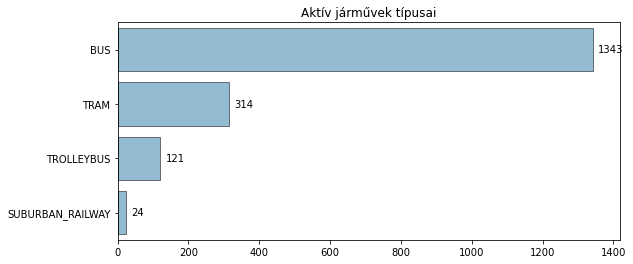

In [23]:
plot_VEHICLES_TYPES()

In [24]:
plot_vehicles_map()

In [25]:
plot_BUS_TYPE('ikarus')

### Trips - so fat can only scrape active trips - worth re running the Vehicle script before

In [26]:
%%time

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
sleep(2)
vehicles = get(vehicles_link, headers = headers).json()['data']

vehicles_rerun = vehicle_df_creator(vehicles)

trips_list = vehicles_rerun.drop_duplicates(['vehicleRouteType', 'shortName', 'From', 'To'])['tripId'].unique().tolist()
trips_list = [i for i in trips_list if isinstance(i, float) == False]
len(trips_list)

Wall time: 2.5 s


268

In [32]:
%%time

trip_dicts = []

pool = Pool(4)

for i in trips_list:
    pool.apply_async(get_trip_details, (i,), callback = trip_dicts.append)

pool.close()
pool.join()

Wall time: 9.29 s


In [37]:
trips_df = pd.DataFrame(trip_dicts)
trips_df.dropna(inplace = True)
print(trips_df.shape)

(260, 4)


In [38]:
trips_df = trips_df.merge(routes)
trips_df.head(3)

id          tripId  num_of_stops  total_distance shortName  type  \
0  BKK_3490   BKK_C36350421            11          5387.0        49  TRAM   
1  BKK_3470   BKK_C21846805            20          8893.0        47  TRAM   
2  BKK_1365  BKK_C367251566             5          4548.0      136E   BUS   

                       From                 To  
0  Kelenföld vasútállomás M  Deák Ferenc tér M  
1              Városház tér  Deák Ferenc tér M  
2   Havanna utcai lakótelep  Kőbánya-Kispest M

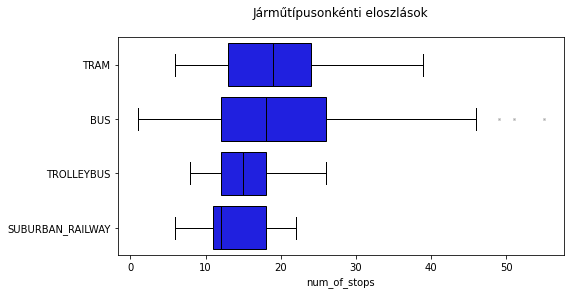

In [61]:
boxplot_sns(trips_df, 'type', 'num_of_stops')

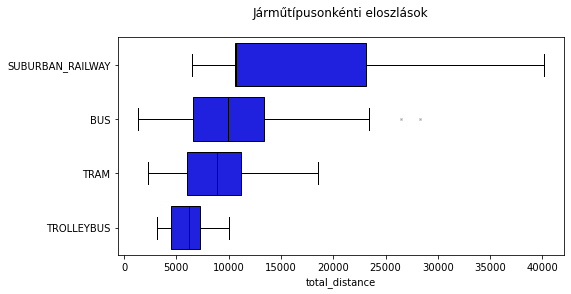

In [62]:
boxplot_sns(trips_df, 'type', 'total_distance')

Legkevesebb megálló

In [74]:
trips_df[trips_df['num_of_stops'] < 5].sort_values('num_of_stops', ascending = True)

id          tripId  num_of_stops  total_distance shortName type  \
194   BKK_8902   BKK_C37523210             1          6267.0         B  BUS   
61    BKK_1005   BKK_C38109391             2         20789.0      100E  BUS   
205   BKK_8903   BKK_C37523302             2         22732.0         C  BUS   
207   BKK_8905   BKK_C37523275             3          7372.0         E  BUS   
75    BKK_VP60   BKK_C36641249             4          1316.0        60  BUS   
90    BKK_1650   BKK_C21515213             4          1412.0       165  BUS   
195   BKK_8904   BKK_C37523252             4          9271.0         D  BUS   
196   BKK_8901   BKK_C37523145             4          5732.0         A  BUS   
210   BKK_1520  BKK_C350341127             4          2118.0       152  BUS   
223  BKK_VP601    BKK_C3723730             4          4674.0       60A  BUS   

                         From                  To  
194         Deák Ferenc tér M            Expó tér  
61     Liszt Ferenc Airport 2   Deák Ferenc tér M  
205           Airport - Monor  Budapest, Expó tér  
207                  Vág utca            Expó tér  
75             Széchenyi-hegy            Svábhegy  
90             Remetehegyi út          Kolosy tér  
195                Vigadó tér            Expó tér  
196  Stadion autóbusz-állomás            Expó tér  
210               Hollandi út      Szent Imre tér  
223        Szent János Kórház         Pethényi út

Legtöbb megálló

In [73]:
trips_df[trips_df['num_of_stops'] > 40].sort_values('num_of_stops', ascending = False)

id          tripId  num_of_stops  total_distance shortName type  \
31   BKK_0880  BKK_C276417845            55         28317.0        88  BUS   
47   BKK_0460  BKK_C369133180            51         23417.0        46  BUS   
161  BKK_1980   BKK_C35248428            49         20254.0       198  BUS   
132  BKK_0050  BKK_C355542074            46         19248.0         5  BUS   
56   BKK_0360   BKK_C32693816            43         19508.0        36  BUS   
159  BKK_2960   BKK_B94521324            41         22820.0       296  BUS   
191  BKK_1400   BKK_C35441707            41         23159.0       140  BUS   

                            From                         To  
31      Budatétény vá. (Campona)   Kelenföld vasútállomás M  
47           Helikopter lakópark    Újpalota, Nyírpalota út  
161  R.csaba-Újtelep, Tóalmás u.   Dél-pesti autóbuszgarázs  
132    Rákospalota, Kossuth utca               Pasaréti tér  
56          Csepel, Csillagtelep  Pestszentlőrinc vasútáll.  
159      B.megyer, Újmegyeri tér  Újpalota, Szentmihályi út  
191  Törökbálint, bevásárlóközp.         Széll Kálmán tér M

Legkisebb távolság

In [72]:
trips_df[trips_df['total_distance'] < 2000].sort_values('total_distance', ascending = True)

id          tripId  num_of_stops  total_distance shortName type  \
75   BKK_VP60   BKK_C36641249             4          1316.0        60  BUS   
90   BKK_1650   BKK_C21515213             4          1412.0       165  BUS   
234  BKK_0161  BKK_C358804158             5          1417.0       16A  BUS   
66   BKK_1160  BKK_C358804150             6          1732.0       116  BUS   
180  BKK_2970    BKK_C2479963             5          1841.0       297  BUS   

               From                         To  
75   Széchenyi-hegy                   Svábhegy  
90   Remetehegyi út                 Kolosy tér  
234        Dísz tér         Széll Kálmán tér M  
66         Dísz tér            Fény utcai piac  
180  Nyeremény utca  R.csaba-Újt. vasútállomás

Legnagyobb távolság

In [71]:
trips_df[trips_df['total_distance'] > 20000].sort_values('total_distance', ascending = False)

id          tripId  num_of_stops  total_distance shortName  \
10     BKK_H6  BKK_H20562_232            22         40115.0        H6   
31   BKK_0880  BKK_C276417845            55         28317.0        88   
18   BKK_1335  BKK_C364671135            38         26427.0      133E   
47   BKK_0460  BKK_C369133180            51         23417.0        46   
191  BKK_1400   BKK_C35441707            41         23159.0       140   
125    BKK_H8   BKK_H1053_331            18         23111.0        H8   
159  BKK_2960   BKK_B94521324            41         22820.0       296   
205  BKK_8903   BKK_C37523302             2         22732.0         C   
124  BKK_0380  BKK_C338144008            35         20842.0        38   
33   BKK_1620   BKK_C35826700            39         20841.0       162   
61   BKK_1005   BKK_C38109391             2         20789.0      100E   
55   BKK_0085  BKK_C365511397            40         20726.0        8E   
121  BKK_1695   BKK_C37663574            26         20426.0      169E   
161  BKK_1980   BKK_C35248428            49         20254.0       198   

                 type                         From                         To  
10   SUBURBAN_RAILWAY                      Ráckeve                 Közvágóhíd  
31                BUS     Budatétény vá. (Campona)   Kelenföld vasútállomás M  
18                BUS      Újpalota, Nyírpalota út   Nagytétény, Erdélyi utca  
47                BUS          Helikopter lakópark    Újpalota, Nyírpalota út  
191               BUS  Törökbálint, bevásárlóközp.         Széll Kálmán tér M  
125  SUBURBAN_RAILWAY                      Gödöllő             Örs vezér tere  
159               BUS      B.megyer, Újmegyeri tér  Újpalota, Szentmihályi út  
205               BUS              Airport - Monor         Budapest, Expó tér  
124               BUS            Szigetszentmiklós     Csepel, Szent Imre tér  
33                BUS        Maglód, Auchan áruház     Kőbánya alsó vasútáll.  
61                BUS       Liszt Ferenc Airport 2          Deák Ferenc tér M  
55                BUS      Újpalota, Nyírpalota út   Kelenföld vasútállomás M  
121               BUS       Pécel, Kun József utca         Örs vezér tere M H  
161               BUS  R.csaba-Újtelep, Tóalmás u.   Dél-pesti autóbuszgarázs

In [250]:
# vehicles_df[vehicles_df['tripId'] == 'BKK_C175521046']

In [251]:
# trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + 'BKK_1634051485889' + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
# get(trip_link, headers = headers).json()

### Stop - todo

In [ ]:
stop_id = 'BKK_F03326' # 45, Anilin --> Ors

stop_schedule_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/schedule-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
stop_vehicle_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stop_route_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/route-details-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stop_arrivals_departures_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/arrivals-and-departures-for-stop.json?includeReferences=agencies,routes,trips,stops&stopId=' + stop_id + '&minutesBefore=1&minutesAfter=30&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch


In [ ]:
# stop_schedule = get(stop_schedule_link, headers = headers).json()['data']
# [{i['routeId'] : i['directions'][0]['stopTimes']} for i in stop_schedule['entry']['schedules']]

In [ ]:
# pd.DataFrame(get(stop_vehicle_link, headers = headers).json()['data']['list'])

In [ ]:
# pd.DataFrame(get(stop_route_link, headers = headers).json()['data']['list']) # NOT NEEDED

In [ ]:
# get(stop_arrivals_departures_link, headers = headers).json()['data']['references']['trips']